In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pickle
import helper_functions
import scipy.io

# read in CNVs that were processed in the R notebook "process_Lee_cnv.ipynb" (that notebook took as input RDS files sent to us from Gavish)

In [29]:
cnv_genes = pd.read_csv("outputs/all_crc_cnvs_long.csv")

# put into a sparse cell x gene matrix

In [16]:
cell_annots = pd.read_csv("data/crc_data/Cells.csv")

In [17]:
genes = pd.read_table("data/crc_data/Genes.txt", header=None)

In [18]:
cell_annots

,cell_name,sample,cell_type,subclone,complexity
0,SMC01-T_AAACCTGAGAAGGTTT,SMC01,T_cell,0,1400
1,SMC01-T_AAACCTGAGGTAGCTG,SMC01,T_cell,0,1249
2,SMC01-T_AAACCTGCATACGCCG,SMC01,Malignant,1,4787
3,SMC01-T_AAACCTGGTCGCATAT,SMC01,Malignant,1,5175
4,SMC01-T_AAACCTGGTTCCTCCA,SMC01,T_cell,0,1245
...,...,...,...,...,...
21652,SMC25-T_TTTGCGCAGACACGAC,SMC25,Malignant,1,5016
21653,SMC25-T_TTTGCGCCATGGAATA,SMC25,NaN,0,3376
21654,SMC25-T_TTTGGTTCAACGCACC,SMC25,B_cell,0,1745
21655,SMC25-T_TTTGGTTGTAGGGTAC,SMC25,Epithelial,0,2765


In [25]:
# in order to create sparse matrix, will want cell idx in .obs, so use that here instead of cell name
# create df with cell indices
cell_idx_df = cell_annots[["cell_name"]].copy().rename(columns={'cell_name':'cell'})
cell_idx_df['cell_idx'] = np.arange(len(cell_annots))

In [30]:
# merge
cnv_array = cell_idx_df.merge(cnv_genes.drop_duplicates(), how="inner")
cnv_array

,cell,cell_idx,gene,log2CNA
0,SMC01-T_AAACCTGAGAAGGTTT,0,MTCO2P12,0.201211
1,SMC01-T_AAACCTGAGAAGGTTT,0,NOC2L,0.174910
2,SMC01-T_AAACCTGAGAAGGTTT,0,HES4,0.137475
3,SMC01-T_AAACCTGAGAAGGTTT,0,ISG15,0.104839
4,SMC01-T_AAACCTGAGAAGGTTT,0,TNFRSF18,0.085997
...,...,...,...,...
39650976,SMC25-T_TTTGTCAAGAGGGATA,21656,ARHGAP4,0.060009
39650977,SMC25-T_TTTGTCAAGAGGGATA,21656,NAA10,0.012727
39650978,SMC25-T_TTTGTCAAGAGGGATA,21656,HCFC1,0.005031
39650979,SMC25-T_TTTGTCAAGAGGGATA,21656,EMD,0.002185


In [32]:
#convert genes to gene_idx
genes.rename(columns={0:'gene'}, inplace=True)
genes['gene_idx'] = np.arange(len(genes))

In [34]:
#merge
cnv_array = genes.merge(cnv_array, on="gene", how="inner")

In [35]:
cnv_array.head()

,gene,gene_idx,cell,cell_idx,log2CNA
0,A1BG,0,SMC02-T_AAACCTGGTGCTTCTC,1742,0.027576
1,A1BG,0,SMC02-T_AAACCTGTCCGATATG,1743,-0.197193
2,A1BG,0,SMC02-T_AAACGGGAGGTGATTA,1744,0.219374
3,A1BG,0,SMC02-T_AAACGGGTCTGCCAGG,1745,0.060256
4,A1BG,0,SMC02-T_AAAGCAAGTTACCAGT,1750,0.128246


In [ ]:
# could convert from log2CNA to dose, but going to skip it here

In [36]:
# create sparse matrix
from scipy.sparse import coo_array, csr_array

cnv_sparse = csr_array((cnv_array.log2CNA, (cnv_array.cell_idx,cnv_array.gene_idx)), shape=[len(cell_annots), len(genes)])

In [37]:
cnv_sparse

<21657x22276 sparse array of type '<class 'numpy.float64'>'
	with 39650981 stored elements in Compressed Sparse Row format>

In [39]:
#pickle formatted infercnv results

# open a file, where you want to store the data
file = open('outputs/cnv_array_crc.pkl', 'wb')

# dump information to that file
pickle.dump(cnv_sparse, file)

# close the file
file.close()

#!gsutil mv outputs/cnv_array_sys.pkl gs://rebecca-summer23/outputs/cnv_array_sys.pkl

# Create anndata object (data downloaded from 3ca for hallmarks/1000 tumors paper)

In [40]:
counts = scipy.io.mmread("data/crc_data/Exp_data_UMIcounts.mtx")

In [41]:
cell_annots = pd.read_csv("data/crc_data/Cells.csv")

In [42]:
genes = pd.read_table("data/crc_data/Genes.txt", header=None)

In [43]:
crc_adata = sc.AnnData(X = np.array(counts.T.todense()), obs = cell_annots.set_index("cell_name"), var=genes.set_index(0))
crc_adata

AnnData object with n_obs × n_vars = 21657 × 22276
    obs: 'sample', 'cell_type', 'subclone', 'complexity'

In [44]:
sc.pp.filter_cells(crc_adata, min_genes=200)
sc.pp.filter_genes(crc_adata, min_cells=3)
crc_adata

AnnData object with n_obs × n_vars = 21657 × 18740
    obs: 'sample', 'cell_type', 'subclone', 'complexity', 'n_genes'
    var: 'n_cells'

In [45]:
crc_adata.layers['counts'] = crc_adata.X.copy()

In [46]:
sc.pp.normalize_total(crc_adata, target_sum=1e4)
sc.pp.log1p(crc_adata)
sc.pp.highly_variable_genes(crc_adata, flavor="seurat_v3", layer="counts", n_top_genes=5000)

In [47]:
crc_adata.raw=crc_adata.copy()

In [48]:
sc.pp.scale(crc_adata, max_value=10)

In [49]:
sc.tl.pca(crc_adata, svd_solver='arpack')

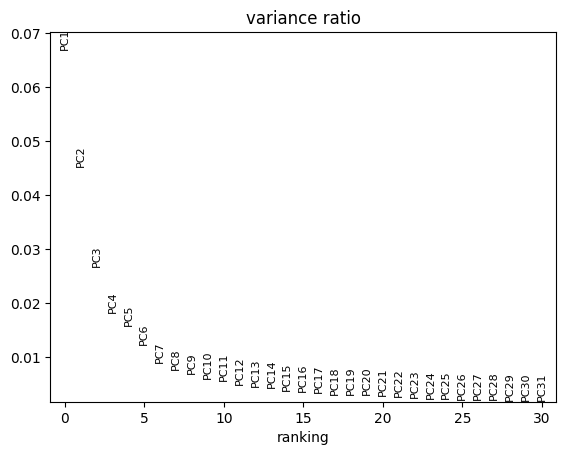

In [50]:
sc.pl.pca_variance_ratio(crc_adata)#, log=True)

In [51]:
sc.pp.neighbors(crc_adata, n_neighbors=10, n_pcs=10)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/dist

In [52]:
sc.tl.umap(crc_adata)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


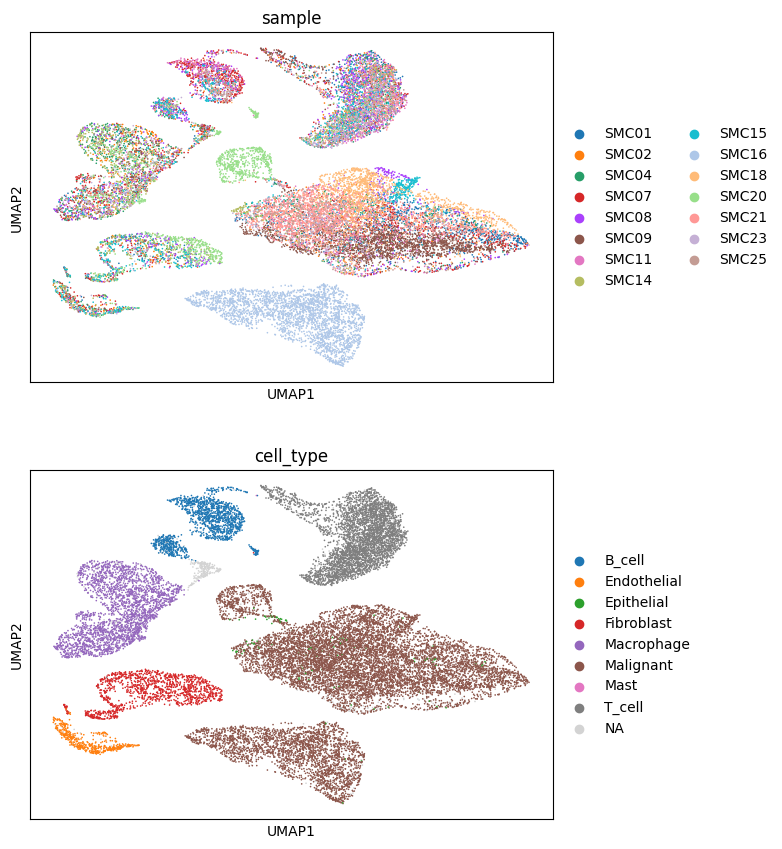

In [53]:
sc.pl.umap(crc_adata, color=['sample','cell_type'], ncols=1)

# Explore PC representation of CNVs

In [54]:
cnv_df = pd.DataFrame(cnv_sparse.todense(), index=crc_adata.obs.index, columns = genes[0])

In [55]:
cnv_dense = cnv_df.loc[:,~np.all(cnv_df==0, axis=0)] #for crc, 0 means no CNV, since working with log 2 data

In [56]:
cnv_dense.shape

(21657, 8716)

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
cnv_pc = pca.fit_transform(cnv_dense)

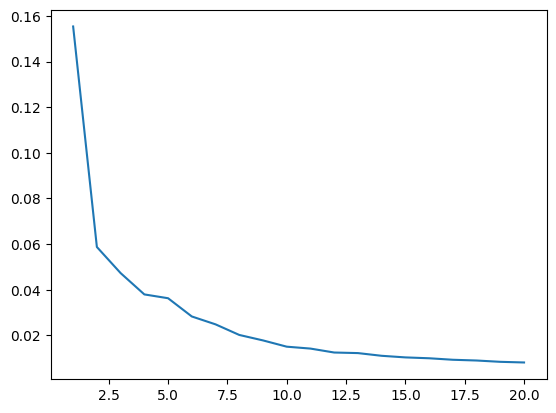

In [58]:
#frac explained variance
import matplotlib.pyplot as plt
plt.plot(np.arange(20)+1, pca.explained_variance_ratio_)

In [59]:
cnv_pc_df = pd.DataFrame(cnv_pc, index=crc_adata.obs.index, columns = ["cnv_PC"+str(i) for i in np.arange(20)+1])

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


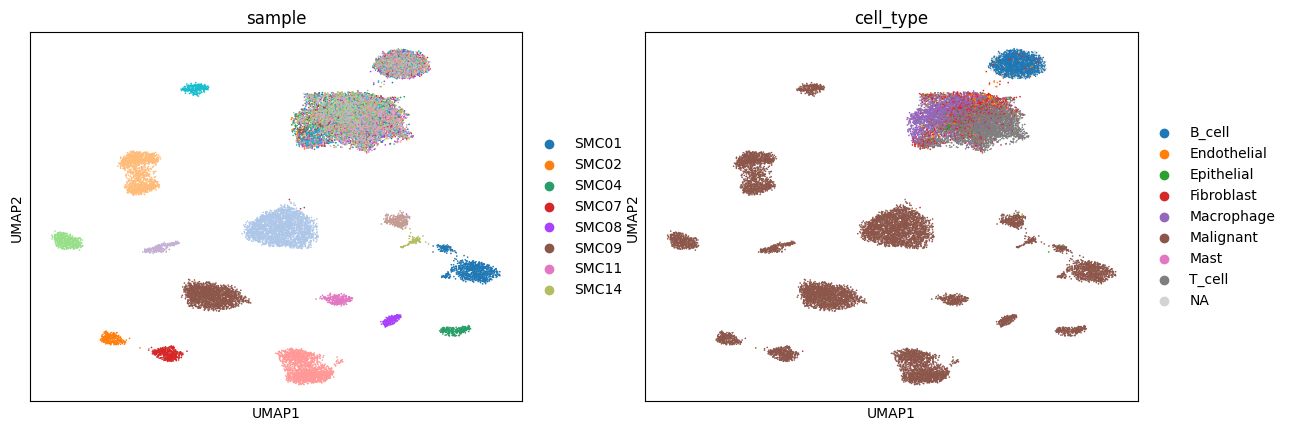

In [61]:
crc_adata.obsm['CNV_pcs'] = cnv_pc_df
sc.pp.neighbors(crc_adata, use_rep='CNV_pcs')
sc.tl.umap(crc_adata)
sc.pl.umap(crc_adata, color=["sample","cell_type"])